In [1]:
%matplotlib inline


.. currentmodule:: dgl

Message Passing Tutorial
========================

**Author**: `Minjie Wang <https://jermainewang.github.io/>`_, Quan Gan, Yu Gai,
Zheng Zhang

In this tutorial, you learn how to use different levels of the message
passing API with PageRank on a small graph. In DGL, the message passing and
feature transformations are **user-defined functions** (UDFs).


The PageRank algorithm
----------------------
In each iteration of PageRank, every node (web page) first scatters its
PageRank value uniformly to its downstream nodes. The new PageRank value of
each node is computed by aggregating the received PageRank values from its
neighbors, which is then adjusted by the damping factor:

\begin{align}PV(u) = \frac{1-d}{N} + d \times \sum_{v \in \mathcal{N}(u)}
   \frac{PV(v)}{D(v)}\end{align}

where $N$ is the number of nodes in the graph; $D(v)$ is the
out-degree of a node $v$; and $\mathcal{N}(u)$ is the neighbor
nodes.



A naive implementation
----------------------
Create a graph with 100 nodes by using ``networkx`` and then convert it to a
:class:`DGLGraph`.



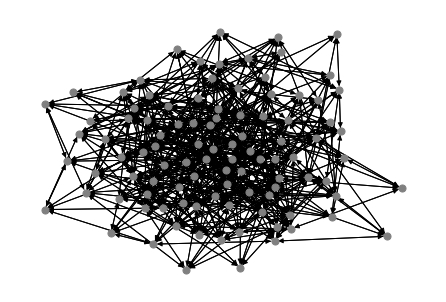

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import torch
import dgl

N = 100  # number of nodes
DAMP = 0.85  # damping factor
K = 10  # number of iterations
g = nx.nx.erdos_renyi_graph(N, 0.1)
g = dgl.from_networkx(g)
nx.draw(g.to_networkx(), node_size=50, node_color=[[.5, .5, .5,]])
plt.show()

According to the algorithm, PageRank consists of two phases in a typical
scatter-gather pattern. Initialize the PageRank value of each node
to $\frac{1}{N}$ and then store each node's out-degree as a node feature.



In [35]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

Define the message function, which divides every node's PageRank
value by its out-degree and passes the result as message to its neighbors.



In [36]:
def pagerank_message_func(edges):
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In DGL, the message functions are expressed as **Edge UDFs**.  Edge UDFs
take in a single argument ``edges``.  It has three members ``src``, ``dst``,
and ``data`` for accessing source node features, destination node features,
and edge features.  Here, the function computes messages only
from source node features.

Define the reduce function, which removes and aggregates the
messages from its ``mailbox``, and computes its new PageRank value.



In [37]:
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['pv'], dim=1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

The reduce functions are **Node UDFs**.  Node UDFs have a single argument
``nodes``, which has two members ``data`` and ``mailbox``.  ``data``
contains the node features and ``mailbox`` contains all incoming message
features, stacked along the second dimension (hence the ``dim=1`` argument).

The message UDF works on a batch of edges, whereas the reduce UDF works on
a batch of edges but outputs a batch of nodes. Their relationships are as
follows:

![](https://i.imgur.com/kIMiuFb.png)


Register the message function and reduce function, which will be called
later by DGL.



In [38]:
g.update_all(pagerank_message_func, pagerank_reduce_func)

The algorithm is straightforward. Here is the code for one
PageRank iteration.



In [46]:
def pagerank_naive(g, pagerank_message_func):
    # Phase #1: send out messages along all edges.
    for u, v in zip(*g.edges()):
        g.apply_edges((u, v), pagerank_message_func)
    # Phase #2: receive messages to compute new PageRank values.
    for v in g.nodes():
        g.recv(v)

In [47]:
pagerank_naive(g, pagerank_message_func)

RuntimeError: Could not infer dtype of function

In [48]:
dgl.__version__

'0.6.0post1'

Batching semantics for a large graph
------------------------------------
The above code does not scale to a large graph because it iterates over all
the nodes. DGL solves this by allowing you to compute on a *batch* of nodes or
edges. For example, the following codes trigger message and reduce functions
on multiple nodes and edges at one time.



In [16]:
def pagerank_batch(g):
    g.send(g.edges())
    g.recv(g.nodes())

In [17]:
pagerank_batch(g)

TypeError: send() missing 1 required positional argument: 'message_func'

You are still using the same reduce function ``pagerank_reduce_func``,
where ``nodes.mailbox['pv']`` is a *single* tensor, stacking the incoming
messages along the second dimension.

You might wonder if this is even possible to perform reduce on all
nodes in parallel, since each node may have different number of incoming
messages and you cannot really "stack" tensors of different lengths together.
In general, DGL solves the problem by grouping the nodes by the number of
incoming messages, and calling the reduce function for each group.



Use higher-level APIs for efficiency
---------------------------------------
DGL provides many routines that combine basic ``send`` and ``recv`` in
various ways. These routines are called **level-2 APIs**. For example, the next code example
shows how to further simplify the PageRank example with such an API.



In [12]:
def pagerank_level2(g):
    g.update_all()

In addition to ``update_all``, you can use ``pull``, ``push``, and ``send_and_recv``
in this level-2 category. For more information, see :doc:`API reference <../../api/python/graph>`.



Use DGL ``builtin`` functions for efficiency
------------------------------------------------
Some of the message and reduce functions are used frequently. For this reason, DGL also
provides ``builtin`` functions. For example, two ``builtin`` functions can be
used in the PageRank example.

* :func:`dgl.function.copy_src(src, out) <function.copy_src>` - This
  code example is an edge UDF that computes the
  output using the source node feature data. To use this, specify the name of
  the source feature data (``src``) and the output name (``out``).

* :func:`dgl.function.sum(msg, out) <function.sum>` - This code example is a node UDF
  that sums the messages in
  the node's mailbox. To use this, specify the message name (``msg``) and the
  output name (``out``).

The following PageRank example shows such functions.



In [13]:
import dgl.function as fn

def pagerank_builtin(g):
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func=fn.copy_src(src='pv', out='m'),
                 reduce_func=fn.sum(msg='m',out='m_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In the previous example code, you directly provide the UDFs to the :func:`update_all <DGLGraph.update_all>`
as its arguments.
This will override the previously registered UDFs.

In addition to cleaner code, using ``builtin`` functions also gives DGL the
opportunity to fuse operations together. This results in faster execution.  For
example, DGL will fuse the ``copy_src`` message function and ``sum`` reduce
function into one sparse matrix-vector (spMV) multiplication.

`The following section <spmv_>`_ describes why spMV can speed up the scatter-gather
phase in PageRank.  For more details about the ``builtin`` functions in DGL,
see :doc:`API reference <../../api/python/function>`.

You can also download and run the different code examples to see the differences.



In [14]:
for k in range(K):
    # Uncomment the corresponding line to select different version.
    # pagerank_naive(g)
    # pagerank_batch(g)
    # pagerank_level2(g)
    pagerank_builtin(g)
print(g.ndata['pv'])

tensor([0.0092, 0.0073, 0.0100, 0.0158, 0.0115, 0.0150, 0.0078, 0.0131, 0.0074,
        0.0058, 0.0091, 0.0107, 0.0081, 0.0132, 0.0100, 0.0161, 0.0048, 0.0067,
        0.0105, 0.0068, 0.0091, 0.0100, 0.0089, 0.0090, 0.0115, 0.0066, 0.0124,
        0.0103, 0.0128, 0.0090, 0.0109, 0.0114, 0.0082, 0.0098, 0.0093, 0.0074,
        0.0097, 0.0108, 0.0115, 0.0110, 0.0117, 0.0090, 0.0098, 0.0103, 0.0091,
        0.0066, 0.0082, 0.0084, 0.0073, 0.0093, 0.0134, 0.0101, 0.0083, 0.0049,
        0.0081, 0.0091, 0.0107, 0.0090, 0.0106, 0.0050, 0.0115, 0.0123, 0.0072,
        0.0114, 0.0132, 0.0076, 0.0141, 0.0091, 0.0145, 0.0115, 0.0068, 0.0074,
        0.0124, 0.0099, 0.0093, 0.0092, 0.0108, 0.0072, 0.0123, 0.0119, 0.0157,
        0.0099, 0.0076, 0.0110, 0.0133, 0.0140, 0.0116, 0.0141, 0.0066, 0.0101,
        0.0099, 0.0099, 0.0066, 0.0074, 0.0076, 0.0139, 0.0126, 0.0100, 0.0093,
        0.0120])



Using spMV for PageRank
-----------------------
Using ``builtin`` functions allows DGL to understand the semantics of UDFs.
This allows you to create an efficient implementation. For example, in the case
of PageRank, one common method to accelerate it is by using its linear algebra
form.

\begin{align}\mathbf{R}^{k} = \frac{1-d}{N} \mathbf{1} + d \mathbf{A}*\mathbf{R}^{k-1}\end{align}

Here, $\mathbf{R}^k$ is the vector of the PageRank values of all nodes
at iteration $k$; $\mathbf{A}$ is the sparse adjacency matrix
of the graph.
Computing this equation is quite efficient because there is an efficient
GPU kernel for the sparse matrix-vector multiplication (spMV). DGL
detects whether such optimization is available through the ``builtin``
functions. If a certain combination of ``builtin`` can be mapped to an spMV
kernel (e.g., the PageRank example), DGL uses it automatically. We recommend 
using ``builtin`` functions whenever possible.



Next steps
----------

* Learn how to use DGL (:doc:`builtin functions<../../features/builtin>`) to write 
  more efficient message passing.
* To see model tutorials, see the :doc:`overview page<../models/index>`.
* To learn about Graph Neural Networks, see :doc:`GCN tutorial<../models/1_gnn/1_gcn>`.
* To see how DGL batches multiple graphs, see :doc:`TreeLSTM tutorial<../models/2_small_graph/3_tree-lstm>`.
* Play with some graph generative models by following tutorial for :doc:`Deep Generative Model of Graphs<../models/3_generative_model/5_dgmg>`.
* To learn how traditional models are interpreted in a view of graph, see 
  the tutorials on :doc:`CapsuleNet<../models/4_old_wines/2_capsule>` and
  :doc:`Transformer<../models/4_old_wines/7_transformer>`.

